In [1]:
import gc
import time

import numpy as np
import pandas as pd

from doc_simp.models.classification import LightningBert, run_classifier
from doc_simp.models.data.bert import BertDataModule

In [2]:
# model_loc = "/media/liam/data2/simp_clf_ckps/1baa289p/checkpoints/epoch=2.ckpt" # exp4 downsamp data bert-base
# model_loc = "/media/liam/data2/simp_clf_ckps/zw9dw7hd/checkpoints/epoch=3.ckpt" # exp4 downsamp data roberta-base
# model_loc = "/media/liam/data2/simp_clf_ckps/3ljk1ut7/checkpoints/epoch=7.ckpt" # exp5 roberta-base no-filter
# model_loc = "/media/liam/data2/simp_clf_ckps/3ljk1ut7/checkpoints/epoch=8.ckpt" # exp5 roberta-base no-filter
# model_loc = "/media/liam/data2/simp_clf_ckps/2zb8ynn5/checkpoints/epoch=7.ckpt" # exp5 roberta-base no-filter simp-only
# model_loc = "/media/liam/data2/simp_clf_ckps/2zb8ynn5/checkpoints/epoch=9-v0.ckpt" # exp5 roberta-base no-filter simp-only
model_loc = "/media/liam/data2/simp_clf_ckps/2zb8ynn5/checkpoints/epoch=final.ckpt" # exp5 roberta-base no-filter simp-only

# model = LightningBert.load_from_checkpoint(model_loc, model_type="bert").to("cuda").eval()
model = LightningBert.load_from_checkpoint(model_loc, model_type="roberta").to("cuda").eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [3]:
# test_set = pd.read_csv("/media/liam/data2/discourse_data/muss/muss_trees.csv")
# test_set = pd.read_csv("/media/liam/data2/discourse_data/wikisplit/wikisplit_trees.csv")
# test_set = pd.read_csv("/media/liam/data2/philtexts/philtext_sents.csv")
# test_set = pd.read_csv("/media/liam/data2/wikilarge/wikilarge_train.csv")
# test_set = pd.read_csv("/media/liam/data2/simp_data/wiki-auto/full_with_split/train.csv")
# test_set = pd.read_csv("/media/liam/data2/simp_data/newsela-auto/newsela-auto/ACL2020/train_joined.csv")

# test_set = pd.read_csv("/media/liam/data2/discourse_data/simp_clf_data/split_clf_valid_exp4.csv")
test_set = pd.read_csv("/media/liam/data2/discourse_data/simp_clf_data/split_clf_valid_exp5_full.csv")
# test_set = pd.read_csv("/media/liam/data2/discourse_data/simp_clf_data/split_clf_valid_exp5_full_0simponly.csv")

input_col = "complex"
max_samples = None
chunk_count = 1

In [4]:
# perform prediction in batches
preds = []
for i, chunk in enumerate(np.array_split(test_set, chunk_count)):
    preds_i = run_classifier(model, chunk, input_col, max_samples=max_samples, device="cuda")
    preds += preds_i
    assert(len(chunk) == len(preds_i))

In [5]:
y_hats = []
correct = []
for i, row in test_set[:max_samples].iterrows():
    logits = preds[i]
    pred = logits.argmax()
    y_hats.append(int(pred))
    correct.append(int(pred) == int(row.label))
test_set["correct"] = correct

In [6]:
test_set["pred"] = y_hats
print("Distribution of predicted labels:")
print(test_set.pred.value_counts())

Distribution of predicted labels:
1    9743
3    7705
2    7316
0    5236
Name: pred, dtype: int64


In [7]:
print(f"Accuracy of model: {sum(correct)/len(y_hats)}")
print("Accuracies per label:")
for label in sorted(test_set.label.unique()):
    items = test_set[test_set.label == label]
    print(f"\t{label}: {sum(items.correct)/len(items)}")

Accuracy of model: 0.9137
Accuracies per label:
	0: 0.7162358408364798
	1: 0.9575413478153543
	2: 0.9661408757138972
	3: 0.9945155393053017


[Text(0.5, 12.5, 'Predicted label'),
 Text(30.5, 0.5, 'True label'),
 Text(0.5, 1.0, 'Operation Classification (no filter)')]

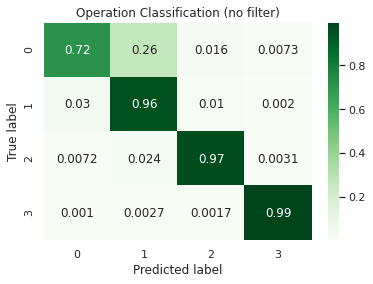

In [8]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

# construct confusion matrix
conf_mat = np.zeros((4, 4))
for label in sorted(test_set.label.unique()):
    items = test_set[test_set.label == label]
    counts = items.pred.value_counts()
    for i, c in counts.iteritems():
        conf_mat[label, i] = c / len(items)

ax = sns.heatmap(conf_mat, annot=True, cmap="Greens")
ax.set(xlabel='Predicted label', ylabel='True label', title="Operation Classification (no filter)")

Accuracies per label:
	0: 0.9406847133757962
Accuracies per label:
	1: 0.9575413478153543
Accuracies per label:
	2: 0.9661408757138972
Accuracies per label:
	3: 0.9945155393053017


[Text(0.5, 12.5, 'Predicted label'),
 Text(30.5, 0.5, 'True label'),
 Text(0.5, 1.0, 'Operation Classification (no filter + simp only)')]

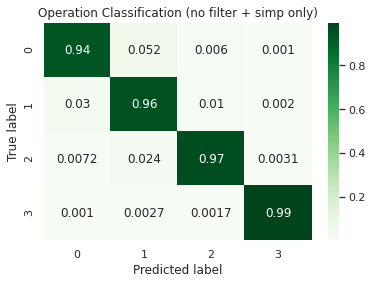

In [9]:
test_set2 = test_set[~((test_set.label == 0) & (test_set.is_simp != True))]

conf_mat = np.zeros((4, 4))
for label in sorted(test_set2.label.unique()):
    print("Accuracies per label:")
    items = test_set2[test_set2.label == label]
    print(f"\t{label}: {sum(items.correct)/len(items)}")
    
    # construct confusion matrix
    counts = items.pred.value_counts()
    for i, c in counts.iteritems():
        conf_mat[label, i] = c / len(items)

ax = sns.heatmap(conf_mat, annot=True, cmap="Greens")
ax.set(xlabel='Predicted label', ylabel='True label', title="Operation Classification (no filter + simp only)")

In [10]:
identicals = test_set[(test_set.label == 0) & (test_set.is_simp != True)]
print(identicals.correct.sum())
print(len(identicals))

206
1862
